In [1]:
import os

import hickle as hkl
import ase.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import tqdm
import e3nn
import e3nn.util
import e3nn.util.test


import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lovelyplots
plt.style.use('ipynb')


/home/ameyad/miniconda3/envs/gaunt-mace/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
structures = ase.io.read('./OHX.xyz', index=':')

In [4]:
species = [structure.get_atomic_numbers() for structure in structures]
assert np.all(species[0] == species)
species = species[0]

In [5]:
positions = [structure.positions for structure in structures]
positions = np.array(positions)

# Center positions with zero mean
positions -= positions.mean(axis=1, keepdims=True)

positions = torch.tensor(positions, dtype=torch.float64)
positions = positions.view(positions.shape[0], -1)
positions.shape

torch.Size([1000, 9])

In [21]:
overlap_tensors = {}
for filename in sorted(os.listdir('./OHHe_blocks')):
    if not filename.endswith('.hickle'):
        continue

    key = filename.split('.')[0]
    overlap_tensors[key] = hkl.load(f'./OHHe_blocks/{filename}')

for key, tensor in overlap_tensors.items():
    print(key, tensor.shape)

H1s-H1s torch.Size([1000, 1, 1])
H1s-H2p torch.Size([1000, 1, 3])
H1s-H2s torch.Size([1000, 1, 1])
H1s-He1s torch.Size([1000, 1, 1])
H1s-He2p torch.Size([1000, 1, 3])
H1s-He2s torch.Size([1000, 1, 1])
H1s-O1s torch.Size([1000, 1, 1])
H1s-O2p torch.Size([1000, 1, 3])
H1s-O2s torch.Size([1000, 1, 1])
H1s-O3d torch.Size([1000, 1, 5])
H1s-O3p torch.Size([1000, 1, 3])
H1s-O3s torch.Size([1000, 1, 1])
H2p-H2p torch.Size([1000, 3, 3])
H2p-He1s torch.Size([1000, 3, 1])
H2p-He2p torch.Size([1000, 3, 3])
H2p-He2s torch.Size([1000, 3, 1])
H2p-O1s torch.Size([1000, 3, 1])
H2p-O2p torch.Size([1000, 3, 3])
H2p-O2s torch.Size([1000, 3, 1])
H2p-O3d torch.Size([1000, 3, 5])
H2p-O3p torch.Size([1000, 3, 3])
H2p-O3s torch.Size([1000, 3, 1])
H2s-H2p torch.Size([1000, 1, 3])
H2s-H2s torch.Size([1000, 1, 1])
H2s-He1s torch.Size([1000, 1, 1])
H2s-He2p torch.Size([1000, 1, 3])
H2s-He2s torch.Size([1000, 1, 1])
H2s-O1s torch.Size([1000, 1, 1])
H2s-O2p torch.Size([1000, 1, 3])
H2s-O2s torch.Size([1000, 1, 1])
H

In [7]:
# Fix convention.
R = np.array([
    [0, 0, 1],  # x = original x (third component)
    [1, 0, 0],  # y = original y (first component)
    [0, 1, 0]   # z = original z (second component)
])
R = torch.tensor(R, dtype=torch.float64)
D0R = e3nn.o3.Irreps("0e").D_from_matrix(R)
D1R = e3nn.o3.Irreps("1o").D_from_matrix(R)
D2R = e3nn.o3.Irreps("2e").D_from_matrix(R)

def get_wigner_D(orbital: str) -> torch.Tensor:
    assert len(orbital) in [3, 4], f'Invalid orbital: {orbital}'
    if 's' in orbital:
        return D0R
    if 'p' in orbital:
        return D1R
    if 'd' in orbital:
        return D2R
    raise ValueError(f'Unknown orbital: {orbital}')


In [8]:

# Fix convention.
for key, tensor in overlap_tensors.items():
    orbitals = key.split('-')
    left_wigner = get_wigner_D(orbitals[0])
    right_wigner = get_wigner_D(orbitals[1])
    overlap_tensors[key] = left_wigner @ tensor @ right_wigner.T

In [9]:
for key, tensor in overlap_tensors.items():
    print(key, tensor.shape)

H1s-H1s torch.Size([1000, 1, 1])
H1s-H2p torch.Size([1000, 1, 3])
H1s-H2s torch.Size([1000, 1, 1])
H1s-He1s torch.Size([1000, 1, 1])
H1s-He2p torch.Size([1000, 1, 3])
H1s-He2s torch.Size([1000, 1, 1])
H1s-O1s torch.Size([1000, 1, 1])
H1s-O2p torch.Size([1000, 1, 3])
H1s-O2s torch.Size([1000, 1, 1])
H1s-O3d torch.Size([1000, 1, 5])
H1s-O3p torch.Size([1000, 1, 3])
H1s-O3s torch.Size([1000, 1, 1])
H2p-H2p torch.Size([1000, 3, 3])
H2p-He1s torch.Size([1000, 3, 1])
H2p-He2p torch.Size([1000, 3, 3])
H2p-He2s torch.Size([1000, 3, 1])
H2p-O1s torch.Size([1000, 3, 1])
H2p-O2p torch.Size([1000, 3, 3])
H2p-O2s torch.Size([1000, 3, 1])
H2p-O3d torch.Size([1000, 3, 5])
H2p-O3p torch.Size([1000, 3, 3])
H2p-O3s torch.Size([1000, 3, 1])
H2s-H2p torch.Size([1000, 1, 3])
H2s-H2s torch.Size([1000, 1, 1])
H2s-He1s torch.Size([1000, 1, 1])
H2s-He2p torch.Size([1000, 1, 3])
H2s-He2s torch.Size([1000, 1, 1])
H2s-O1s torch.Size([1000, 1, 1])
H2s-O2p torch.Size([1000, 1, 3])
H2s-O2s torch.Size([1000, 1, 1])
H

In [10]:
def get_irreps(orbital: str) -> str:
    assert len(orbital) in [3, 4], f'Invalid orbital: {orbital}'
    if 's' in orbital:
        return e3nn.o3.Irrep("0e")
    if 'p' in orbital:
        return e3nn.o3.Irrep("1o")
    if 'd' in orbital:
        return e3nn.o3.Irrep("2e")
    raise ValueError(f'Unknown orbital: {orbital}')


def construct_rtp(orbitals: str) -> nn.Module:
    left, right = orbitals.split('-')
    return e3nn.o3.ReducedTensorProducts(
        "ij",
        i=get_irreps(left),
        j=get_irreps(right),
    )

In [11]:
def reduce_overlap_tensor(overlap_tensor, rtp):
    cob = rtp.change_of_basis.to(overlap_tensor.dtype)
    return rtp.irreps_out, torch.einsum('kij,...ij->...k', cob, overlap_tensor)

def restore_overlap_tensor(overlap_tensor, rtp):
    cob = rtp.change_of_basis.to(overlap_tensor.dtype)
    return torch.einsum('kij,...k->...ij', cob, overlap_tensor)

In [12]:
rtps = {
    key: construct_rtp(key) for key in overlap_tensors.keys()
}

overlap_tensors_reduced = {
    key: reduce_overlap_tensor(value, rtps[key]) for key, value in overlap_tensors.items()
}

In [13]:
output_irreps = [ir for ir, _ in overlap_tensors_reduced.values()]
output_irreps_concat = sum([ir for ir in output_irreps], start=e3nn.o3.Irreps())
output_irreps_dims = [ir.dim for ir in output_irreps]
output_irreps_slices = [slice(sum(output_irreps_dims[:i]), sum(output_irreps_dims[:i+1])) for i in range(len(output_irreps_dims))]
output_tensors_concat = torch.cat([t for _, t in overlap_tensors_reduced.values()], dim=-1)

output_irreps_concat, output_irreps_slices, output_tensors_concat.shape

(1x0e+1x1o+1x0e+1x0e+1x1o+1x0e+1x0e+1x1o+1x0e+1x2e+1x1o+1x0e+1x0e+1x1e+1x2e+1x1o+1x0e+1x1e+1x2e+1x1o+1x1o+1x0e+1x1e+1x2e+1x1o+1x1o+1x2o+1x3o+1x0e+1x1e+1x2e+1x1o+1x1o+1x0e+1x0e+1x1o+1x0e+1x0e+1x1o+1x0e+1x2e+1x1o+1x0e+1x0e+1x1o+1x0e+1x0e+1x1o+1x0e+1x2e+1x1o+1x0e+1x0e+1x1e+1x2e+1x1o+1x0e+1x1e+1x2e+1x1o+1x1o+1x2o+1x3o+1x0e+1x1e+1x2e+1x1o+1x1o+1x0e+1x0e+1x1o+1x0e+1x2e+1x1o+1x0e+1x0e+1x1o+1x0e+1x2e+1x1o+1x0e+1x0e+1x1e+1x2e+1x1o+1x2o+1x3o+1x0e+1x1e+1x2e+1x1o+1x1o+1x0e+1x2e+1x1o+1x0e+1x0e+1x1e+1x2e+1x3e+1x4e+1x1o+1x2o+1x3o+1x0e+1x1e+1x2e+1x2e+1x1o+1x0e,
 [slice(0, 1, None),
  slice(1, 4, None),
  slice(4, 5, None),
  slice(5, 6, None),
  slice(6, 9, None),
  slice(9, 10, None),
  slice(10, 11, None),
  slice(11, 14, None),
  slice(14, 15, None),
  slice(15, 20, None),
  slice(20, 23, None),
  slice(23, 24, None),
  slice(24, 33, None),
  slice(33, 36, None),
  slice(36, 45, None),
  slice(45, 48, None),
  slice(48, 51, None),
  slice(51, 60, None),
  slice(60, 63, None),
  slice(63, 78, None),

In [14]:
print(output_irreps_concat.regroup())

39x0e+32x1o+11x1e+4x2o+18x2e+4x3o+1x3e+1x4e


In [15]:
edges = torch.tensor([
    [0, 1],
    [1, 0],
    [2, 1],
    [1, 2],
    [2, 0],
    [0, 2],
], dtype=torch.long)



class EquivariantMPNNLayer(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, node_features, edges, coords):
        senders = edges[:, 0]
        receivers = edges[:, 1]

        # Compute the message
        coords_senders = coords[senders]
        coords_receivers = coords[receivers]
        coords_edges = coords_receivers - coords_senders

        senders_features = node_features[..., senders]
        receivers_features = node_features[..., receivers]

        sh_edges = e3nn.o3.spherical_harmonics(
            l=e3nn.o3.Irreps.spherical_harmonics(2),
            x=coords_edges,
            normalization='component',
        )
        sh_tp = e3nn.o3.TensorProduct(
            irreps_in1=self.irreps_in1,
            irreps_in2=e3nn.o3.Irreps.spherical_harmonics(2),
            irreps_out=self.irreps_out,
        )(senders_features, sh_edges)

        # Aggregate the messages
        aggregated = torch_scatter.scatter(
            sh_tp,
            receivers,
            dim=1,
            dim_size=node_features.shape[-1],
            reduce='sum',
        )

        # Perform 

        



@e3nn.util.jit.compile_mode('trace')
class EquivariantMPNN(nn.Module):

    def __init__(self, irreps_in, irreps_hidden, irreps_out, num_layers):
        super().__init__()

        self.irreps_in = irreps_in
        self.irreps_hidden = irreps_hidden
        self.irreps_out = irreps_out

        self.linear_in = e3nn.o3.Linear(irreps_in, irreps_hidden)

        self.tps = nn.ModuleList()
        self.linears = nn.ModuleList()
        self.activations = nn.ModuleList()
        for _ in range(num_layers):
            self.tps.append(
                e3nn.o3.FullyConnectedTensorProduct(
                    irreps_hidden,
                    irreps_hidden,
                    irreps_hidden,
                )
            )
            self.activations.append(
                e3nn.nn.NormActivation(
                    self.tps[-1].irreps_out,
                    scalar_nonlinearity=nn.SELU(),
                )
            )
            self.linears.append(e3nn.o3.Linear(self.tps[-1].irreps_out, irreps_hidden))
        
        self.linear_out = e3nn.o3.Linear(irreps_hidden, irreps_out)
        self.equivariance_tested = False

    def forward(self, x):
        if not self.equivariance_tested:
            self.equivariance_tested = True
            e3nn.util.test.assert_equivariant(
                self.forward,
                args_in=(x,),
                irreps_in=self.irreps_in,
                irreps_out=self.irreps_out,
            )
    

        x = self.linear_in(x)
        for tp, activation, linear in zip(self.tps, self.activations, self.linears):
            x_prev = x
            x = tp(x, x)
            x = activation(x)
            x = linear(x)
            x = x + x_prev
        x = self.linear_out(x)
        return x

In [16]:
@e3nn.util.jit.compile_mode('trace')
class EquivariantMLP(nn.Module):

    def __init__(self, irreps_in, irreps_hidden, irreps_out, num_layers):
        super().__init__()

        self.irreps_in = irreps_in
        self.irreps_hidden = irreps_hidden
        self.irreps_out = irreps_out

        self.linear_in = e3nn.o3.Linear(irreps_in, irreps_hidden)

        self.tps = nn.ModuleList()
        self.linears = nn.ModuleList()
        self.activations = nn.ModuleList()
        for _ in range(num_layers):
            self.tps.append(
                e3nn.o3.FullyConnectedTensorProduct(
                    irreps_hidden,
                    irreps_hidden,
                    irreps_hidden,
                )
            )
            self.activations.append(
                e3nn.nn.NormActivation(
                    self.tps[-1].irreps_out,
                    scalar_nonlinearity=nn.SELU(),
                )
            )
            self.linears.append(e3nn.o3.Linear(self.tps[-1].irreps_out, irreps_hidden))
        
        self.linear_out = e3nn.o3.Linear(irreps_hidden, irreps_out)
        self.equivariance_tested = False

    def forward(self, x):
        if not self.equivariance_tested:
            self.equivariance_tested = True
            e3nn.util.test.assert_equivariant(
                self.forward,
                args_in=(x,),
                irreps_in=self.irreps_in,
                irreps_out=self.irreps_out,
            )
    
        x = self.linear_in(x)
        for tp, activation, linear in zip(self.tps, self.activations, self.linears):
            x_prev = x
            x = tp(x, x)
            x = activation(x)
            x = linear(x)
            x = x + x_prev
        x = self.linear_out(x)
        return x

In [17]:
hidden_lmax = 5
irreps_hidden = "80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o"

# hidden_channels = 8
# irreps_hidden = e3nn.o3.Irreps.spherical_harmonics(hidden_lmax, p=-1)
# irreps_hidden += e3nn.o3.Irreps.spherical_harmonics(hidden_lmax, p=1)
# irreps_hidden *= hidden_channels
# irreps_hidden = irreps_hidden.regroup()

model = EquivariantMLP(
    irreps_in=e3nn.o3.Irreps("3x1o"),
    irreps_hidden=irreps_hidden,
    irreps_out=output_irreps_concat,
    num_layers=3,
)

model.to(positions.dtype).to(device)

EquivariantMLP(
  (linear_in): Linear(3x1o -> 80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o | 96 weights)
  (tps): ModuleList(
    (0): FullyConnectedTensorProduct(80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o x 80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o -> 80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o | 1380096 paths | 1380096 weights)
    (1): FullyConnectedTensorProduct(80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o x 80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o -> 80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o | 1380096 paths | 1380096 weights)
    (2): FullyConnectedTensorProduct(80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o x 80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o -> 80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e+4x5o | 1380096 paths | 1380096 weights)
  )
  (linears): ModuleList(
    (0): Linear(80x0e+32x1o+16x1e+8x2o+24x2e+4x3o+4x3e+4x4e+4x4o+4x5e

In [18]:
# Print the number of parameters and the device
sum(p.numel() for p in model.parameters() if p.requires_grad), next(model.parameters()).device

(4170440, device(type='cuda', index=0))

In [19]:
positions = positions.to(device)
output_tensors_concat = output_tensors_concat.to(device)

num_train = 500
num_test = 100
splits =  [num_train, len(positions) - num_test - num_train, num_test]

positions_train, positions_val, positions_test = torch.split(positions, splits, dim=0)
output_tensors_concat_train, output_tensors_concat_val, output_tensors_concat_test = torch.split(output_tensors_concat, splits, dim=0)
positions_train.shape, output_tensors_concat_train.shape

(torch.Size([500, 9]), torch.Size([500, 322]))

In [20]:
# Training loop
raise ValueError('This cell is not meant to be run.')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

all_results = {}
with tqdm.trange(10000) as progress:
    for step in progress:
        batch = torch.randperm(len(positions_train))[:batch_size]

        positions_batch = positions_train[batch]
        output_tensors_concat_batch = output_tensors_concat_train[batch]
        # print(positions_batch[0], output_tensors_concat_batch[0])

        optimizer.zero_grad()
        preds = model(positions_batch)
        loss = torch.nn.functional.mse_loss(preds, output_tensors_concat_batch)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            with torch.inference_mode():
                train_rel_error = torch.norm(preds - output_tensors_concat_batch) / torch.norm(output_tensors_concat_batch)

                val_preds = model(positions_val)
                val_loss = torch.nn.functional.mse_loss(val_preds, output_tensors_concat_val)
                val_rel_error = torch.norm(val_preds - output_tensors_concat_val) / torch.norm(output_tensors_concat_val)

                results = {
                    "loss": loss.item(),
                    "rel_error": train_rel_error.item(),
                    "val_loss": val_loss.item(),
                    "val_rel_error": val_rel_error.item(),
                } 
                all_results[step] = results

                progress.set_postfix(results)



ValueError: This cell is not meant to be run.

In [136]:
# Save model and results
torch.save(model.state_dict(), './model.pt')
hkl.dump(all_results, './all_results.hickle')

In [ ]:
steps = list(all_results.keys())
val_losses = [all_results[step]["val_loss"] for step in steps]
train_losses = [all_results[step]["loss"] for step in steps]

plt.plot(steps, val_losses, label="Validation")
plt.plot(steps, train_losses, label="Training")
plt.yscale('log')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Water Hamiltonians')
plt.ticklabel_format(style='plain', axis='x')
plt.legend()
plt.show()

In [ ]:
steps = list(all_results.keys())
val_rel_errors = [all_results[step]["val_rel_error"] for step in steps]
train_rel_errors = [all_results[step]["rel_error"] for step in steps]

plt.plot(steps, val_rel_errors, label="Validation")
plt.plot(steps, train_rel_errors, label="Training")
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Relative Error')
plt.title('Water Hamiltonians')
plt.legend()
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [165]:
# Choose a structure
val_index = 120

In [191]:
pos = positions_val[val_index].cpu().numpy().reshape(-1, 3)
fig = go.Figure(data=[
    go.Scatter3d(x=pos[:, 0], y=pos[:, 1], z=pos[:, 2],
                 mode='markers+text',
                 marker=dict(size=12, color=['red', 'blue', 'green']),
                 text=['O', 'H<sub>1</sub>', 'H<sub>2</sub>'], 
                textposition='top center')
])
fig.update_layout(scene=dict(aspectmode='cube'))
# Make the axes bigger
fig.update_layout(scene=dict(xaxis=dict(range=[-1.5, 1.5]),
                             yaxis=dict(range=[-1.5, 1.5]),
                             zaxis=dict(range=[-1.5, 1.5])))
fig.show()

In [167]:
def get_orbital_labels(orbital: str):
    assert len(orbital) in [3, 4], f'Invalid orbital: {orbital}'

    if "s" in orbital:
        return ["$\sqrt{x^2 + y^2 + z^2}$"]
    
    if "p" in orbital:
        return ["$x$", "$y$", "$z$"]

    if "d" in orbital:
        return ["$xz$", "$xy$", "$2y^2 - z^2 - x^2$", "$yz$", "$z^2 - x^2$"]
    
    raise ValueError(f"Unknown orbital {orbital}")

In [ ]:
preds = model(positions_val[val_index]).cpu()
true = output_tensors_concat_val[val_index].cpu()


for ir, overlap, rtp, slicer in zip(output_irreps, rtps.keys(), rtps.values(), output_irreps_slices):
    preds_block = restore_overlap_tensor(preds[slicer], rtp).detach().numpy()
    true_block = restore_overlap_tensor(true[slicer], rtp).detach().numpy()

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    vmax = max(abs(true_block.min()), abs(true_block.max()))
    im = axs[0].imshow(true_block, cmap='RdBu', vmin=-vmax, vmax=vmax)
    _ = axs[1].imshow(preds_block, cmap='RdBu', vmin=-vmax, vmax=vmax)
    axs[0].set_title('True')
    axs[1].set_title('Predicted')

    for ax in axs:
        left, right = overlap.split('-')
        ax.set_yticks(range(preds_block.shape[0]))
        ax.set_yticklabels(get_orbital_labels(left))
        ax.set_xticks(range(preds_block.shape[1]))
        ax.set_xticklabels(get_orbital_labels(right))

    # Reduce font size for tick labels
    axs[0].tick_params(axis='both', which='major', labelsize=8)
    axs[1].tick_params(axis='both', which='major', labelsize=8)

    fig.suptitle(f'{overlap.replace("_", "-")} Overlap')
    fig.colorbar(im, ax=axs, orientation='horizontal')
    plt.show()

In [188]:
left_order = ["H1s", "H2s", "H2p"]
left_dims = [get_irreps(orbital).dim for orbital in left_order]
left_slices = [slice(sum(left_dims[:i]), sum(left_dims[:i+1])) for i in range(len(left_dims))]
left_labels = [f"{orbital}" for orbital in left_order for label in get_orbital_labels(orbital)]

right_order = ["O1s", "O2s", "O2p", "O3s", "O3p", "O3d"]
right_dims = [get_irreps(orbital).dim for orbital in right_order]
right_slices = [slice(sum(right_dims[:i]), sum(right_dims[:i+1])) for i in range(len(right_dims))]
right_labels = [f"{orbital}" for orbital in right_order for label in get_orbital_labels(orbital)]

preds = model(positions_val[val_index]).cpu()
true = output_tensors_concat_val[val_index].cpu()

pred_hamiltonian = np.zeros((sum(left_dims), sum(right_dims)))
true_hamiltonian = np.zeros((sum(left_dims), sum(right_dims)))

indices = []
for index, overlap in enumerate(overlap_tensors_reduced.keys()):
    left, right = overlap.split("-")
    if left[0] == "H" and left[:2] != "He" and right[0] == "O":
        rtp = rtps[overlap]
        ir_slicer = output_irreps_slices[index]
        preds_block = restore_overlap_tensor(preds[ir_slicer], rtp).detach().numpy()
        true_block = restore_overlap_tensor(true[ir_slicer], rtp).detach().numpy()

        left_slice = left_slices[left_order.index(left)]
        right_slice = right_slices[right_order.index(right)]

        pred_hamiltonian[left_slice, right_slice] = preds_block
        true_hamiltonian[left_slice, right_slice] = true_block

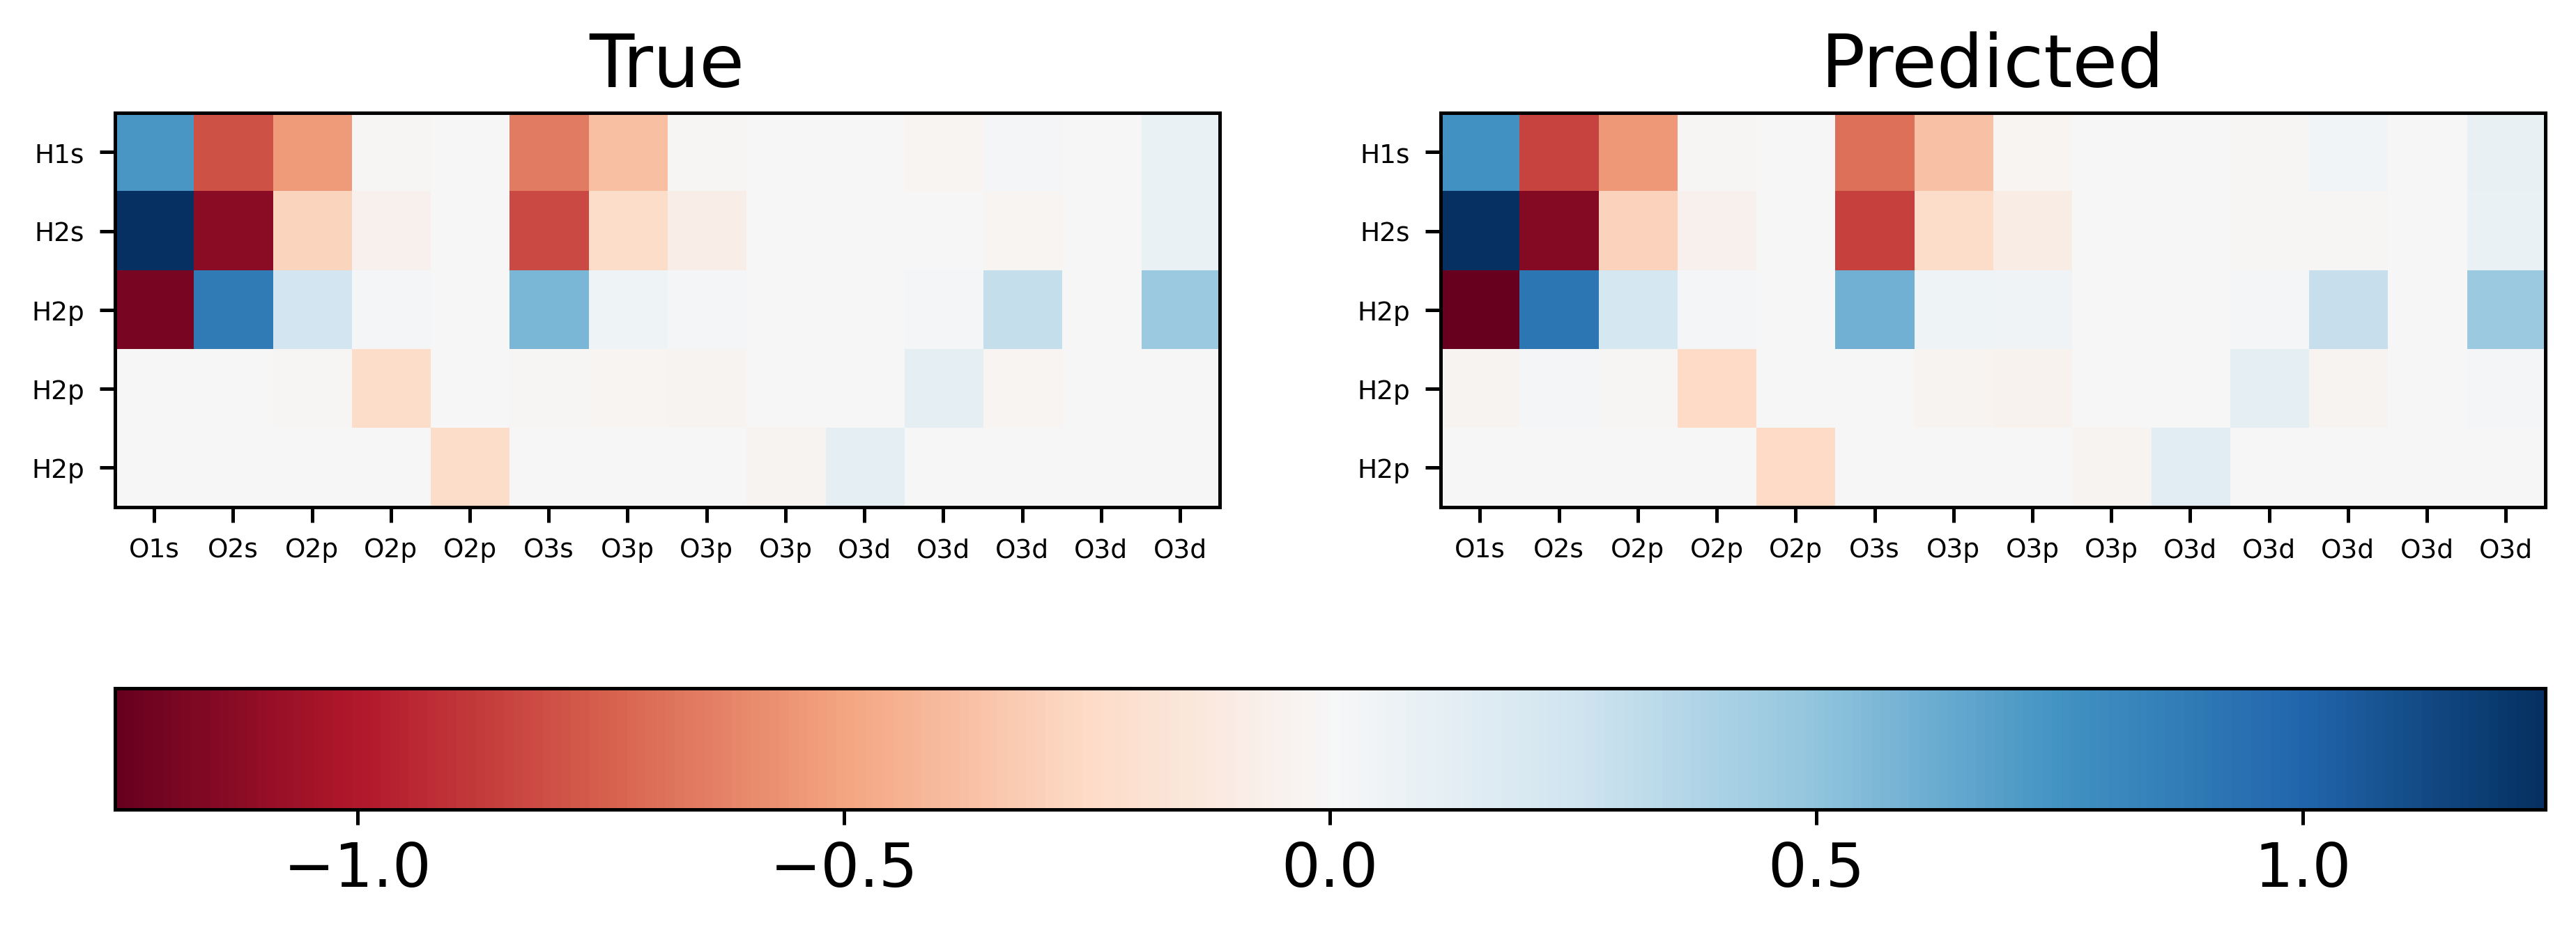

In [192]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
vmax = max(abs(true_hamiltonian.min()), abs(true_hamiltonian.max()))
im = axs[0].imshow(true_hamiltonian, cmap='RdBu', vmin=-vmax, vmax=vmax)
_ = axs[1].imshow(pred_hamiltonian, cmap='RdBu', vmin=-vmax, vmax=vmax)
fig.colorbar(im, ax=axs, orientation='horizontal')
axs[0].set_title('True')
axs[1].set_title('Predicted')

for ax in axs:
    ax.set_yticks(range(len(left_labels)))
    ax.set_yticklabels(left_labels)
    ax.set_xticks(range(len(right_labels)))
    ax.set_xticklabels(right_labels)

    ax.tick_params(axis='both', which='major', labelsize=6)

